In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from grasp_baseline.inference import GraspDetector
from grasp_baseline.utils import visualize, center_crop

In [2]:
#detector = GraspDetector(yolo_cfg='') # Use selective search
detector = GraspDetector(cuda=True) 

In [2]:
img = cv2.imread('./example_imgs/rgb_image.png', cv2.IMREAD_COLOR)[...,::-1]
depth = cv2.imread('./example_imgs/depth_image.png', cv2.IMREAD_GRAYSCALE)
#depth[depth==depth.max()] = 0
#img[depth==0] = 0

In [4]:
np.save('./example_imgs/depth_image.npy', depth, allow_pickle=True, fix_imports=True)

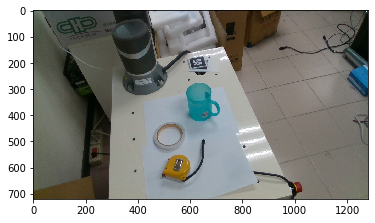

In [4]:
plt.imshow(img)
plt.show()

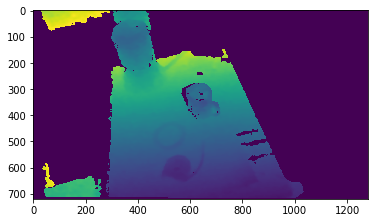

In [5]:
plt.imshow(depth)
plt.show()

In [6]:
%time bboxes, degs, confs, centers, cats, scores = detector.detect([img], [depth], threshold=-2, yolo_threshold=0.05)

CPU times: user 1.13 s, sys: 75.5 ms, total: 1.2 s
Wall time: 1.19 s


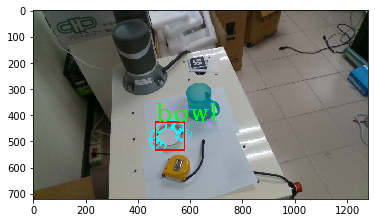

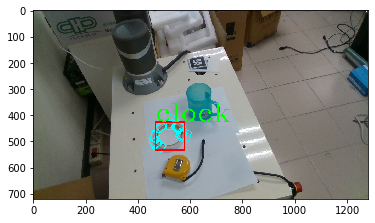

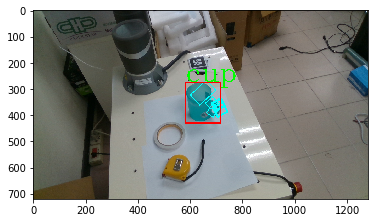

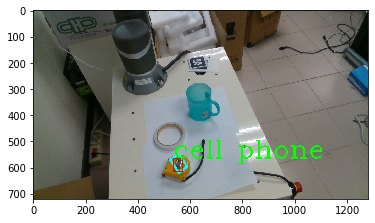

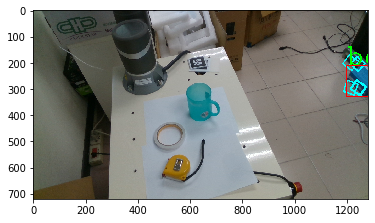

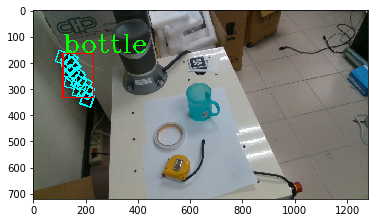

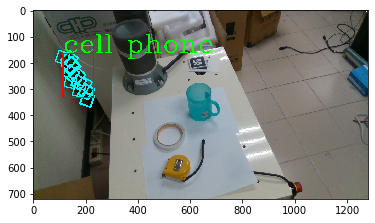

In [7]:
visualize([img], bboxes, confs, centers, cats)

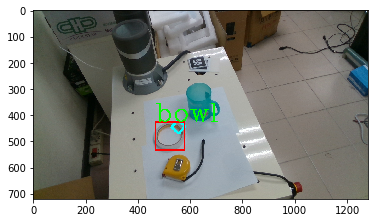

In [8]:
visualize([img], [[[bboxes[0][0][0]]]], [[confs[0][0]]], [[centers[0][0]]], [[cats[0][0]]])